# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)
pd.set_option('display.max_columns', 30)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import time
import pickle

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_lg', disable = 'parser')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Define sub-functions

In [2]:
# printing functions
def explore_data_cleaning(raw_df):
    trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
    ax.set_title('Number of Trigger Types');

    for p in ax.patches:
        ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')

    #https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots
    return

In [3]:
# function to get data 
def get_data():
    # Import the CSV file
    raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_16_20.csv')
    raw_df = raw_df.dropna(how='all')
    return raw_df

# function to clean data
def clean_data(raw_df, print_fns=False):
    # project out extra columns
    raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]
    
    # Convert each category to Title format (to remove discrepancies based on capitalization)
    raw_df['Trigger'] = raw_df['Trigger'].str.title()

    # Some data fixes
    raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')
    raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

    # Some dollar sign symbols are causing problems - will remove them here
    raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

    # Drop Multiclass column since it isn't needed
    raw_df = raw_df.drop('Multiclass', axis = 1)
    
    # Count the number of distinct documents
    num_docs = raw_df['Document'].nunique()
    print(f'{num_docs} unique documents have been included in the data set')
    
    # Summarize the trigger counts for the existing Document set
    max_triggers = raw_df['Document'].value_counts().max()
    min_triggers = raw_df['Document'].value_counts().min()
    print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

    # run the extra code that analyzes the data
    if print_fns:
        explore_data_cleaning(raw_df)
        
    return raw_df


In [4]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']

    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)

    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')

        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
        
    # replace nulls with False
    reshaped = reshaped.fillna(0)  
    
    return reshaped

In [5]:
# Shall we create doc view and remove the extraneous document without tags?

In [6]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

In [7]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [8]:
# NLP processing the sentence columns to prep for models
def tokenize_sentences(dataframe):
    print('Tokenizing the input sentences...')
    dataframe['SentenceTokens'] = dataframe['Sentence'].apply(tokenize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')
    dataframe['SentenceLemmas'] = dataframe['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')
    print(f"{len(dataframe['Sentence'])} sentences have been tokenized and lemmatized.")
    print("\n")
    return dataframe

In [9]:
# Incorporate Stopwords
def get_stopwords():
    # might need space
    short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a', 'marriott']
    short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'marriott']
    stopwords = list(STOP_WORDS) + ['marriott']

    return short_stopwords, short_stopwords2, stopwords

In [10]:
# function to split data for each target column (trigger type)
def get_split_data(df, target_info):
    # extract target name
    target = target_info['target']
    model_input  = target_info['model_input']
    
    # create X, Y
    X = df[model_input]
    y = df[target]
    indices = df.index

    print(f"Number of distinct labeled document/sentence combinations within the full data set: {y.value_counts()[1]}")   
    
    y = y.astype('int')

    # run test, train split
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)

    
    # create output dictionary
    split_data = {}
    split_data['X_train'] = X_train
    split_data['X_test'] = X_test
    split_data['y_train'] = y_train
    split_data['y_test'] = y_test
    split_data['indices_train'] = indices_train
    split_data['indices_test'] = indices_test
    
    return split_data

In [11]:
# run the model with the chosen model and metric
def run_model(split_data, target_info):

    # get stopwords
    short_stopwords, short_stopwords2, stopwords = get_stopwords()
    
    # set pipeline according to the selected model:
    if target_info['model'] == 'lr':
        # Define CVEC + Logistic Regression Pipeline
        pipe = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
        params = {
            'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7)],
            'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
            'cvec__max_features': [100, 200, 400, 600, 1000],
            'cvec__min_df': [2],
            'cvec__max_df': [.99],
            }

    elif target_info['model'] == 'rf':
        # Define CVEC + Logistic Regression Pipeline
        pipe = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
        params = {
            'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
            'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
            'cvec__max_features': [100, 200, 400, 800],
            'cvec__min_df': [2],
            'cvec__max_df': [.99],
            'rf__max_depth': [4,5, 6],
            'rf__min_samples_split': [2,3],
            'rf__min_samples_leaf': [10, 12]
            }

    
    else:
        print('did not specify model throw error')

    # define pipeline
    gs_model = GridSearchCV(pipe, param_grid = params, cv = 3, scoring = target_info['metric'])

    # Start the timer.
    t0 = time.time()

    # extract X_train and y_train
    X_train = split_data['X_train']
    y_train = split_data['y_train']
    
    # run pipeline
    model_result = gs_model.fit(X_train, y_train)

    print(f"Seconds elapsed for fitting: {(time.time() - t0):.3f}") # How many seconds elapsed.   
    return model_result


## Main Control Function - runs the full model for all target types

In [12]:
# Control of the main project

# define dictionary of targets contains: tag, model, metric, input, order
target_dict = {}
target_dict['nontrigger'] = {'target': 'nontrigger', 'model': 'lr', 'metric': 'roc_auc', 'model_input': 'SentenceLemmas'}
target_dict['loan_default'] = {'target': 'loan_default', 'model': 'lr', 'metric':'roc_auc', 'model_input':'SentenceLemmas'}
target_dict['unspecified'] = {'target': 'unspecified', 'model': 'lr', 'metric':'roc_auc', 'model_input':'SentenceLemmas'}
target_dict['debt_yield_fall'] = {'target': 'debt_yield_fall', 'model': 'lr', 'metric': 'roc_auc', 'model_input': 'SentenceLemmas'}
target_dict['mezzanine_default'] = {'target': 'mezzanine_default', 'model': 'lr', 'metric': 'roc_auc', 'model_input': 'SentenceLemmas'}
target_dict['bankruptcy'] = {'target': 'bankruptcy', 'model': 'lr', 'metric': 'roc_auc', 'model_input': 'SentenceLemmas'}
target_dict['tenant_failure'] = {'target': 'tenant_failure', 'model': 'lr', 'metric': 'roc_auc', 'model_input': 'SentenceLemmas'}
target_dict['renovations'] = {'target': 'renovations', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['aggregate_debt_yield_fall'] = {'target': 'aggregate_debt_yield_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['dscr_fall'] = {'target': 'dscr_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['operator_termination'] = {'target': 'operator_termination', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['sponsor_termination'] = {'target': 'sponsor_termination', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['sff'] = {'target': 'sff', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['mezzanine_outstanding'] = {'target': 'mezzanine_outstanding', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['aggregate_dscr_fall'] = {'target': 'aggregate_dscr_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
target_dict['delayed_repayment'] = {'target': 'delayed_repayment', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}


# set output_dict - will contain target + output of calculations
output_dict = {}

# get data
raw_df = get_data()
raw_df = clean_data(raw_df)

# Reshape our original dataframe and tokenize to prepare sentences for models
df = reshape_trigger_representation(raw_df)
df = tokenize_sentences(df)

# run for each model definition
for k,v in target_dict.items():
    
    print(f"{target_dict[k]['target'].replace('_', ' ').title()}: creating Train-Test split")
    # get split data
    split_data = get_split_data(df, v)
    
    print(f"Model fit in progress: {target_dict[k]}")
    # run model
    model_result = run_model(split_data, v)
    
    # make the output dictionary
    output_dict[k] = v
    output_dict[k]['split_data'] = split_data
    output_dict[k]['model_result'] = model_result

    
    print(f"Best fit parameters: {model_result.best_params_}")
    print(f"Best fit 3-fold cross validation score: {model_result.best_score_:.3f}")
    print(f"{target_dict[k]['target'].replace('_', ' ').title()} {target_dict[k]['metric']} Train score: {model_result.score(split_data['X_train'], split_data['y_train']):.3f}")
    print(f"{target_dict[k]['target'].replace('_', ' ').title()} {target_dict[k]['metric']} Test score: {model_result.score(split_data['X_test'], split_data['y_test']):.3f}")
    print("\n")
    
    output_dict[k]['best_params'] = model_result.best_params_
    output_dict[k]['count_deduplicated'] = df[target_dict[k]['target']].value_counts()[1]
    output_dict[k]['test_data_count'] = output_dict[k]['split_data']['y_test'].value_counts()[1]
    output_dict[k]['best_crossval_score'] = model_result.best_score_
    output_dict[k]['train_score'] = model_result.score(split_data['X_train'], split_data['y_train'])
    output_dict[k]['test_score'] = model_result.score(split_data['X_test'], split_data['y_test'])                                                  
    
    '''
    outfile = open(f"../data/models/{target_dict[k]['target']}_pickle", 'wb')
    pickle.dump(model_result, outfile)
    outfile.close()
    '''
    

full_output_dict = [output_dict[key] for key in output_dict.keys()]
results_df = pd.DataFrame.from_dict(full_output_dict)
    
print("Modeling complete!")





/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

36 unique documents have been included in the data set
The 36 Documents have tag counts that range from 25 to 176.
Tokenizing the input sentences...
2280 sentences have been tokenized and lemmatized.


Nontrigger: creating Train-Test split
Number of distinct labeled document/sentence combinations within the full data set: 1030
Model fit in progress: {'target': 'nontrigger', 'model': 'lr', 'metric': 'roc_auc', 'model_input': 'SentenceLemmas'}
Seconds elapsed for fitting: 204.976
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['ca', 'among', 'itself', 'ours', 'serious', 'each', 'mine', 'fifteen', 'one', 'before', 'except', 'hundred', 'some', 'seem', 'same', 'they', 'somewhere', 'under', 'is', 'only', 'using', 'less', 'thereupon', 'further', 'whereas', 'do', 'others', 'or', 'whereafter', 'being', 'as', 'eleven', 'himself', 'always', 'say', 'somehow', 'you', 'someone', 'once', 'throughout', 'these'

Seconds elapsed for fitting: 200.895
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 100, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['ca', 'among', 'itself', 'ours', 'serious', 'each', 'mine', 'fifteen', 'one', 'before', 'except', 'hundred', 'some', 'seem', 'same', 'they', 'somewhere', 'under', 'is', 'only', 'using', 'less', 'thereupon', 'further', 'whereas', 'do', 'others', 'or', 'whereafter', 'being', 'as', 'eleven', 'himself', 'always', 'say', 'somehow', 'you', 'someone', 'once', 'throughout', 'these', 'down', 'where', 'made', 'than', 'their', 'well', 'herself', 'hereafter', 'would', 'while', 'he', 'amount', 'so', 'whole', 'latterly', 'already', 'meanwhile', 'she', 'alone', 'your', 'empty', 'nine', 'very', 'whose', 'below', 'formerly', 'herein', 'such', 'hers', 'are', 'have', 'out', 'an', 'but', 'nobody', 'own', 'few', 'i', 'whereupon', 'yet', 'otherwise', 'because', 'seemed', 'its', 'upon', 'of', 'various', 'two', 'from', 'to', 'noone', '

Aggregate Debt Yield Fall: creating Train-Test split
Number of distinct labeled document/sentence combinations within the full data set: 19
Model fit in progress: {'target': 'aggregate_debt_yield_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
Seconds elapsed for fitting: 196.942
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 600, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'marriott']}
Best fit 3-fold cross validation score: 0.546
Aggregate Debt Yield Fall f1 Train score: 1.000
Aggregate Debt Yield Fall f1 Test score: 0.800


Dscr Fall: creating Train-Test split
Number of distinct labeled document/sentence combinations within the full data set: 23
Model fit in progress: {'target': 'dscr_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
Seconds elapsed for fitting: 201.127
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 10

Sff f1 Test score: 0.000


Mezzanine Outstanding: creating Train-Test split
Number of distinct labeled document/sentence combinations within the full data set: 8
Model fit in progress: {'target': 'mezzanine_outstanding', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
Seconds elapsed for fitting: 200.659
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 400, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'marriott']}
Best fit 3-fold cross validation score: 0.389
Mezzanine Outstanding f1 Train score: 0.909
Mezzanine Outstanding f1 Test score: 0.000


Aggregate Dscr Fall: creating Train-Test split
Number of distinct labeled document/sentence combinations within the full data set: 8
Model fit in progress: {'target': 'aggregate_dscr_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'SentenceLemmas'}
Seconds elapsed for fitting: 203.467
Best fit parameters: {'cvec__max_df': 0

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-def

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/

Seconds elapsed for fitting: 201.573
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 100, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}
Best fit 3-fold cross validation score: 0.000
Delayed Repayment f1 Train score: 1.000
Delayed Repayment f1 Test score: 0.000


Modeling complete!


In [13]:
# Print a summary table with all fitting results
results_df

,target,model,metric,model_input,split_data,model_result,best_params,count_deduplicated,test_data_count,best_crossval_score,train_score,test_score
0,nontrigger,lr,roc_auc,SentenceLemmas,{'X_train': [' trigger period mean a period a ...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 1...",1030,309,0.986957,0.999823,0.985937
1,loan_default,lr,roc_auc,SentenceLemmas,{'X_train': ['upon the occurrence of a lockbox...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 4...",553,166,0.982374,0.999221,0.991220
2,unspecified,lr,roc_auc,SentenceLemmas,{'X_train': ['any fund remain in the reserve a...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 1...",498,149,0.965063,0.999828,0.964248
3,debt_yield_fall,lr,roc_auc,SentenceLemmas,{'X_train': [' approve operating expense mean ...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 2...",188,56,0.976745,0.999974,0.993375
4,mezzanine_default,lr,roc_auc,SentenceLemmas,{'X_train': ['borrower hereby represent and wa...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 1...",72,22,0.949262,1.000000,0.994850
5,bankruptcy,lr,roc_auc,SentenceLemmas,{'X_train': ['hard lockbox and spring cash man...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 2...",44,13,0.832279,0.999897,0.995529
6,tenant_failure,lr,roc_auc,SentenceLemmas,{'X_train': ['follow the occurrence and prior ...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 2...",74,22,0.957538,1.000000,0.999863
7,renovations,lr,f1,SentenceLemmas,{'X_train': ['see description of the mortgage ...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 1...",26,8,0.755556,0.888889,0.933333
8,aggregate_debt_yield_fall,lr,f1,SentenceLemmas,{'X_train': ['the mortgage lender will make di...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 6...",19,6,0.546032,1.000000,0.800000
9,dscr_fall,lr,f1,SentenceLemmas,{'X_train': ['upon the write request of mortga...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 1...",23,7,0.616667,1.000000,0.750000


In [14]:
# Export summary table
results_df.to_csv(f'../data/exported_data/results_df_06_16_20.csv')


## Plotting functions: features and confusion matrices

In [15]:
def coefficient_plots(results_df):
    '''
    Plots the top 10 and bottom 10 coefficients for each category
    '''
    for row in results_df.itertuples(index = True, name = 'Pandas'):
        names = getattr(row, "model_result").best_estimator_.steps[0][1].get_feature_names()
        betas = getattr(row, "model_result").best_estimator_.named_steps['lr']
        coef = np.array(betas.coef_).tolist()[0]
        top_words = list(zip(names, coef))
        df_coefs = pd.DataFrame(top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)
        

        coefs_1 = df_coefs.sort_values(by = 'coef', ascending=False).tail(10) # getting the top 10 coefficients
        coefs_2 = df_coefs.sort_values(by = 'coef', ascending=False).head(10) # getting the bottom 10 coefficients
        coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
        # plotting importance
        plt.figure(figsize=(10, 8)) # plotting the coefficients
        plt.title(f'Feature Coefficients for {getattr(row,"target").replace("_", " ").title()}', fontsize=25)
        sns.set_style("darkgrid")
        sns.barplot(data=coefs,
                    x= 'coef',
                    y='word',
                    orient='h',
                    palette = 'PuBuGn_d')
        plt.xlabel('coefficient', fontsize=15)
        plt.ylabel('feature', fontsize=15)
        plt.tick_params(labelsize=15)


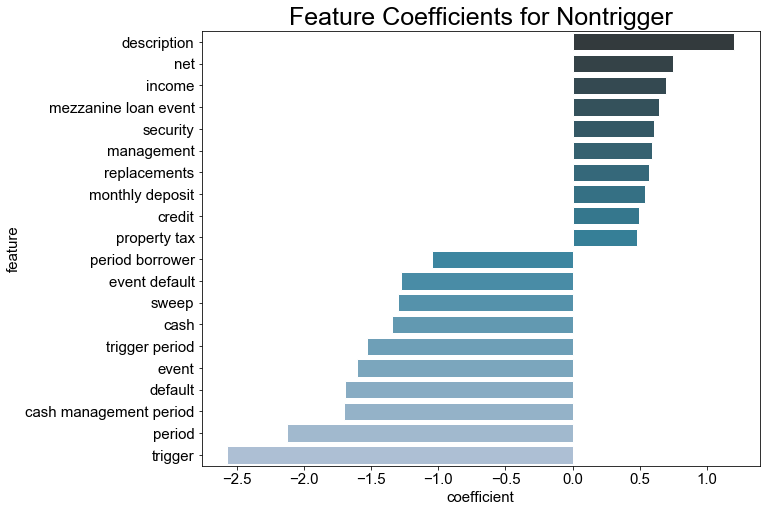

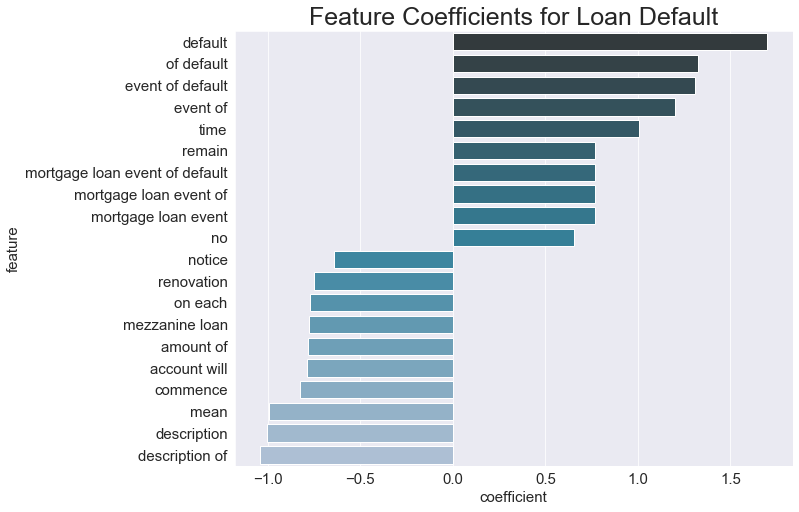

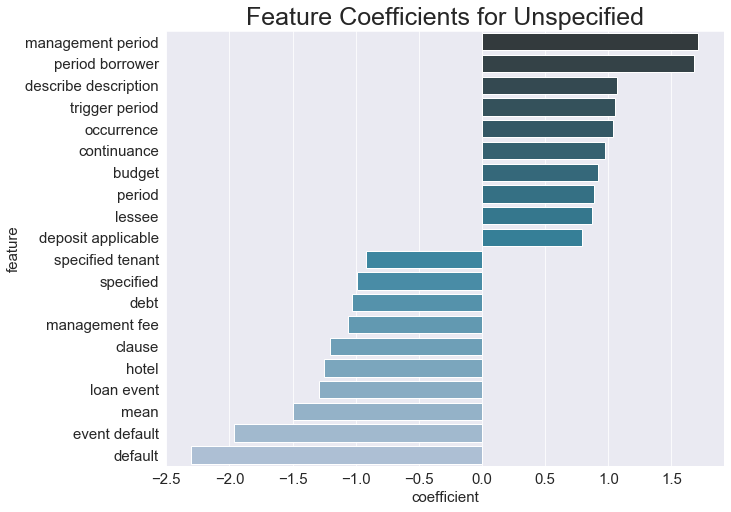

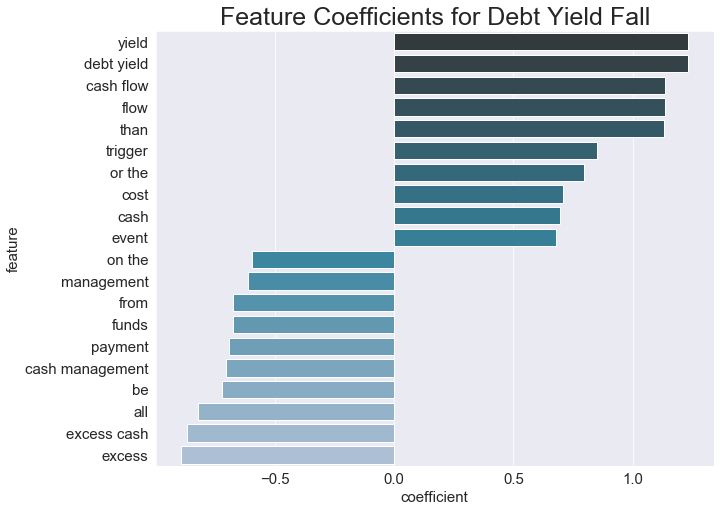

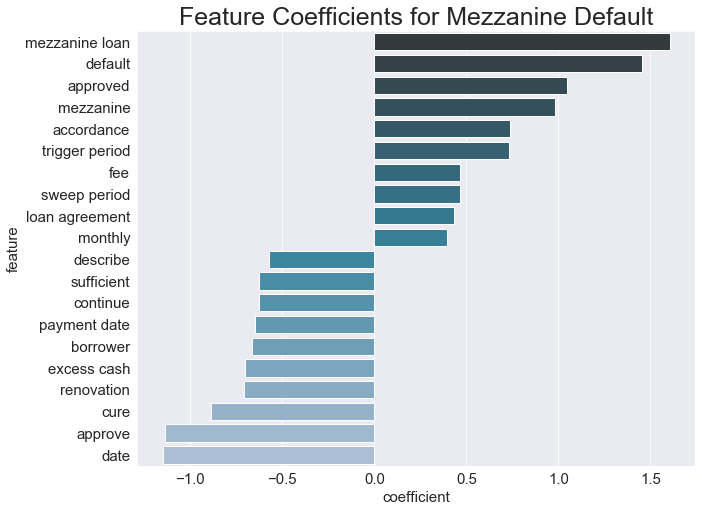

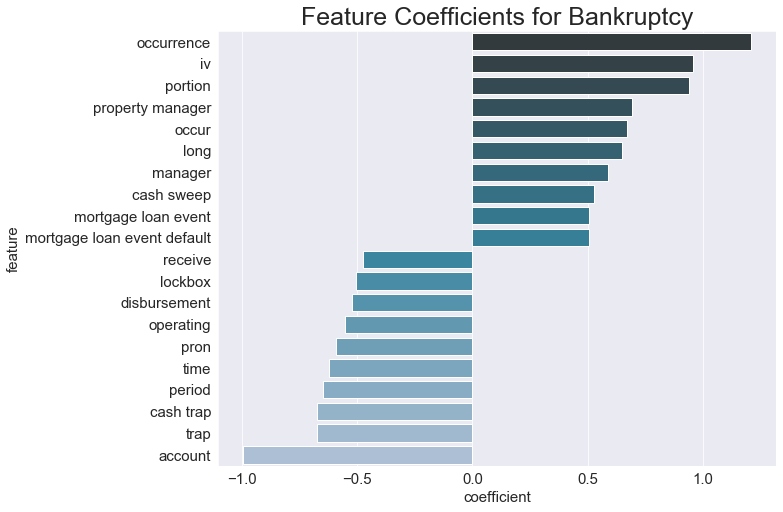

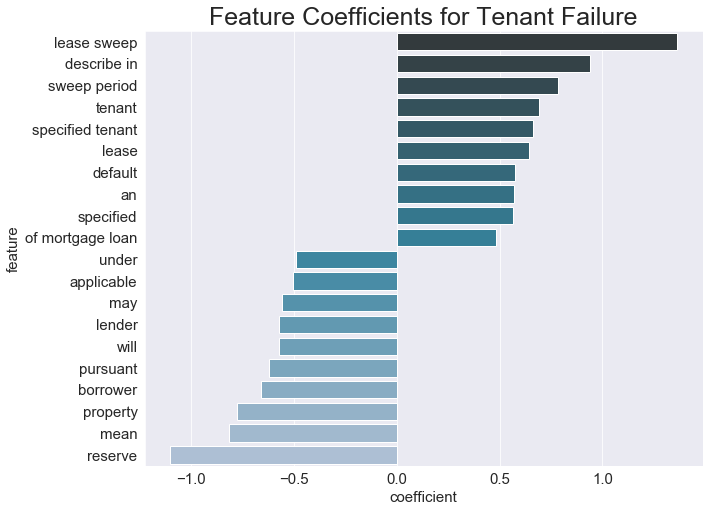

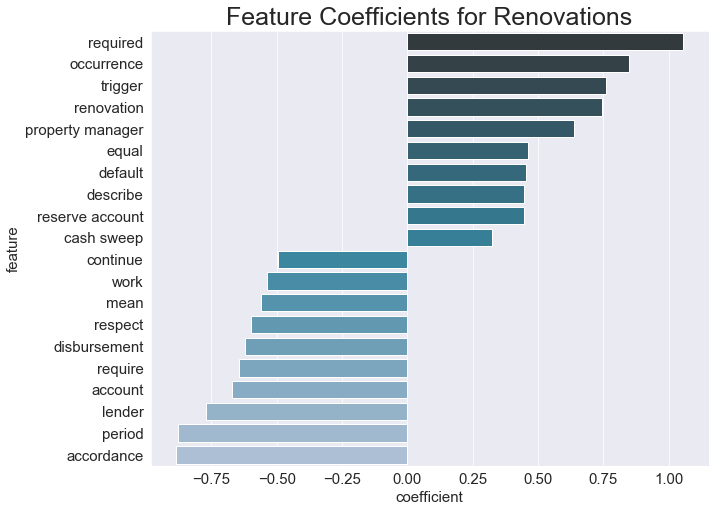

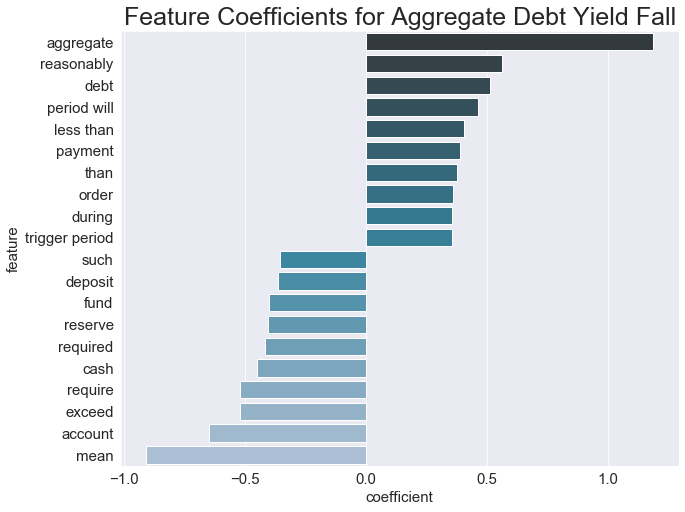

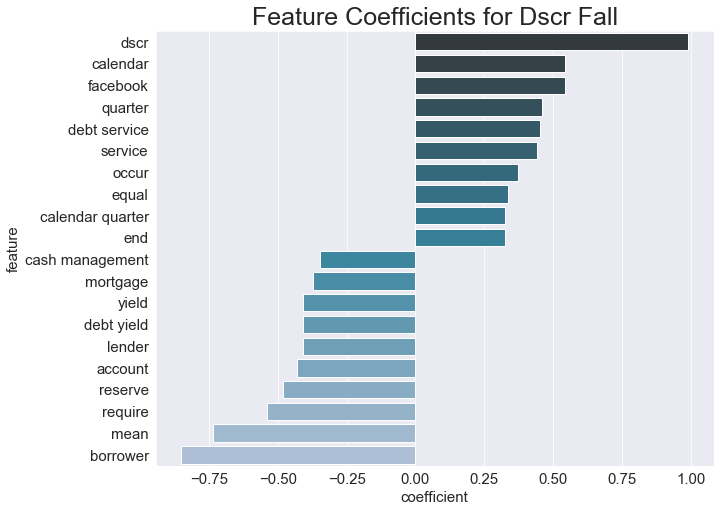

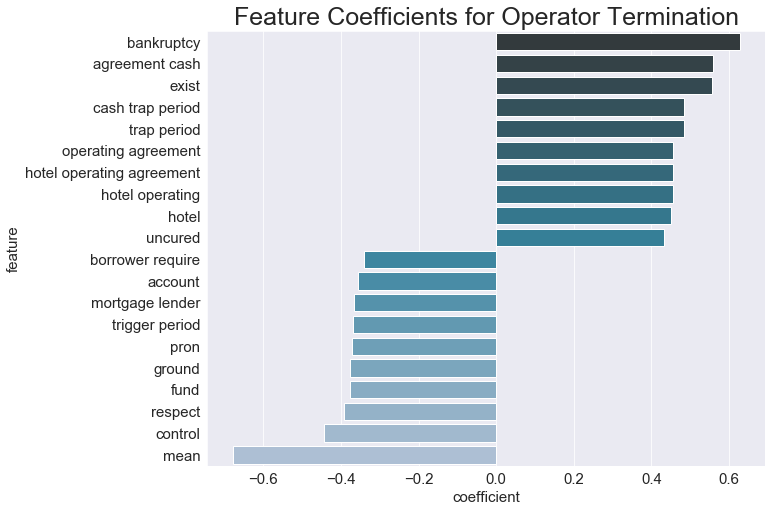

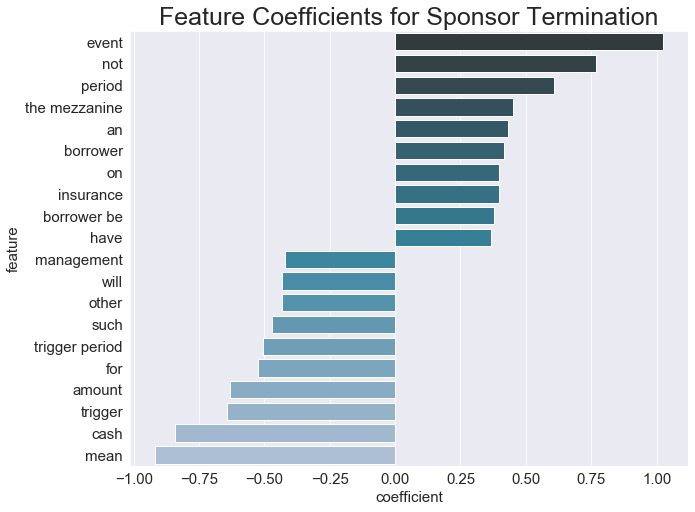

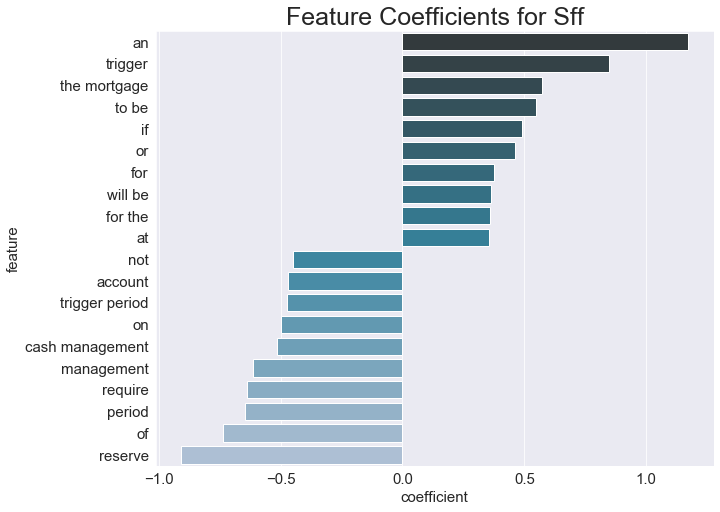

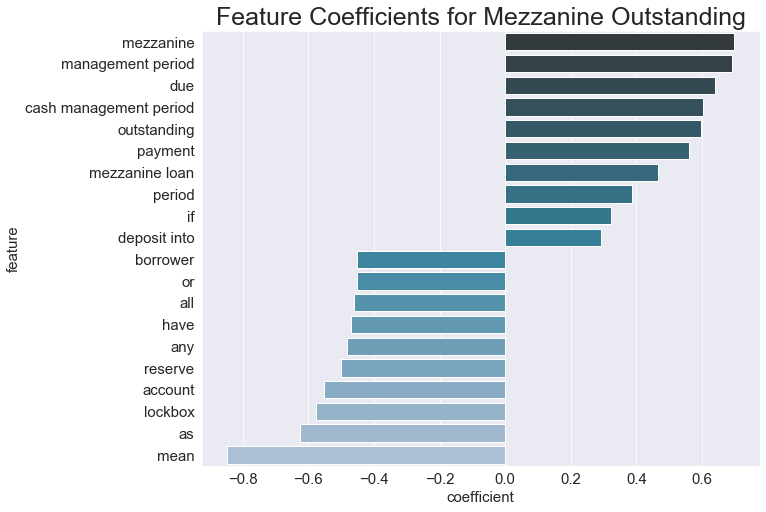

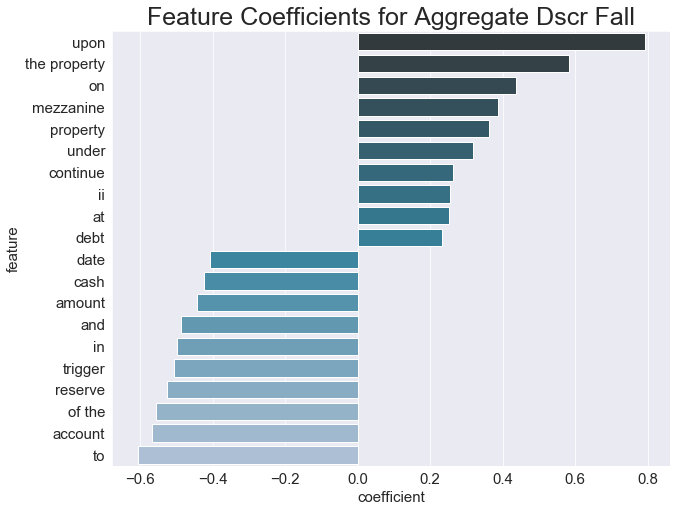

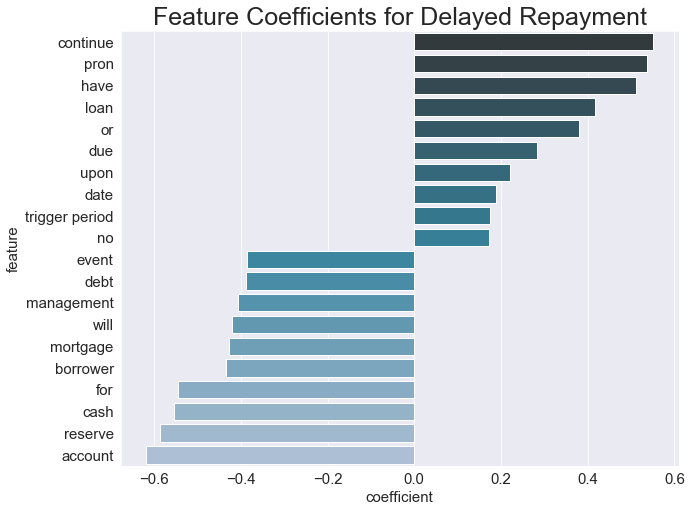

In [16]:
# Call the coefficient plot function
coefficient_plots(results_df)

In [17]:
def create_confusion_matrix(results_df):
    '''
    Plots the top 10 and bottom 10 coefficients for each category
    '''
    for row in results_df.itertuples(index = True, name = 'Pandas'):
        best_model = getattr(row, "model_result").best_estimator_
        preds = best_model.predict(getattr(row, "split_data")['X_test'])
        
        cm_test = confusion_matrix(getattr(row, "split_data")['y_test'], preds)
        cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])
        plt.figure(figsize = (6,6))
        ax = plt.subplot()
        sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

        # labels, title and ticks
        ax.set_title(f'Confusion Matrix - {getattr(row,"target").replace("_", " ").title()}', size=16)
        ax.set_xlabel('Predicted', size=14)
        ax.set_ylabel('Actual', size=14)
        ax.xaxis.set_ticklabels(['Negative', 'Positive'])
        ax.yaxis.set_ticklabels(['Negative', 'Positive']);

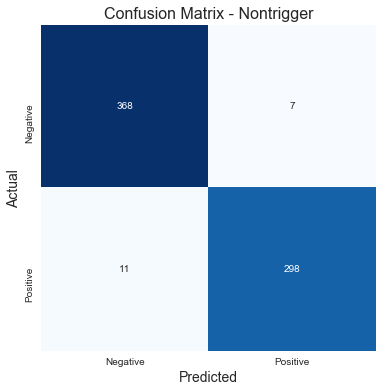

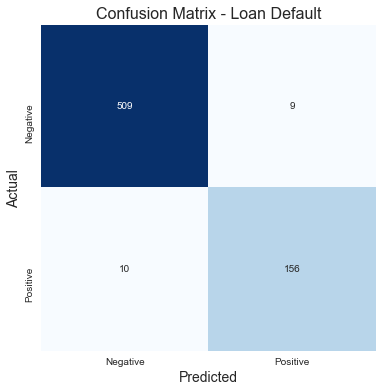

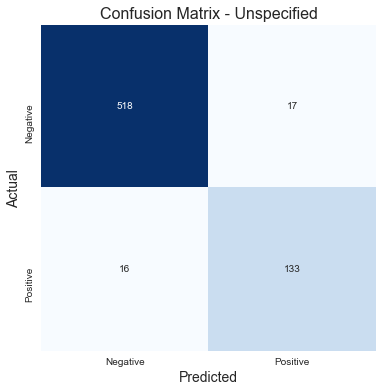

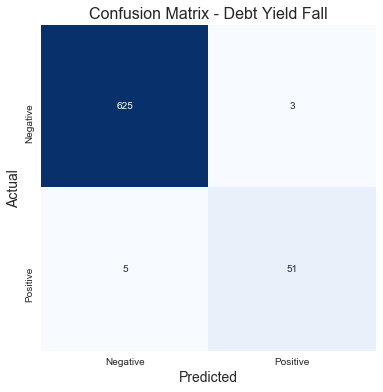

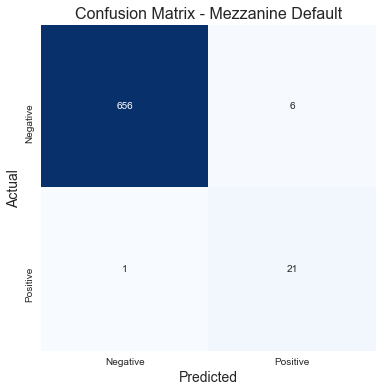

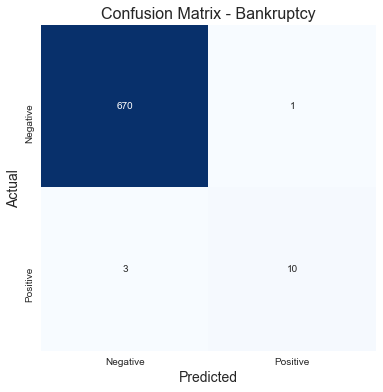

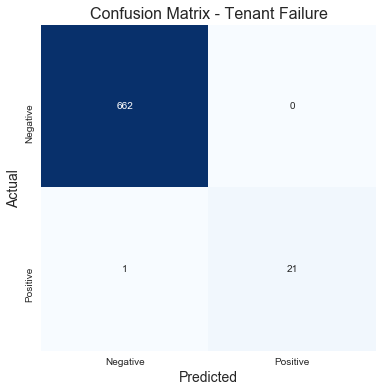

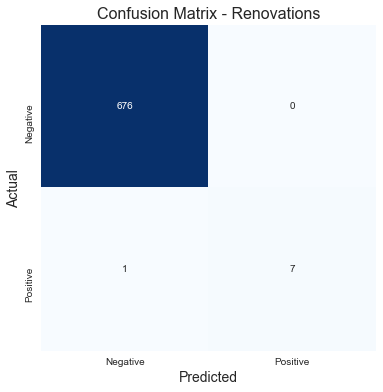

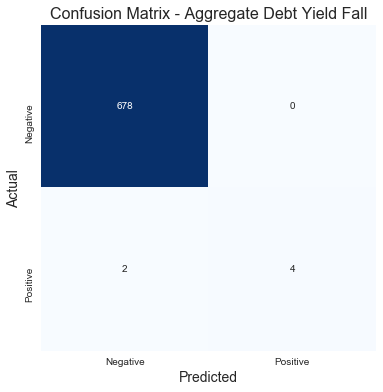

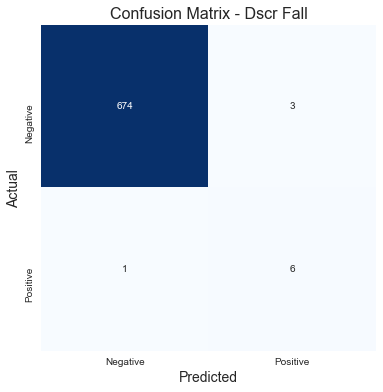

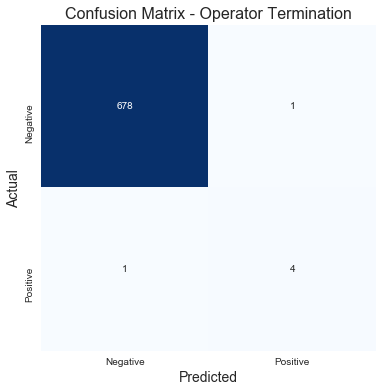

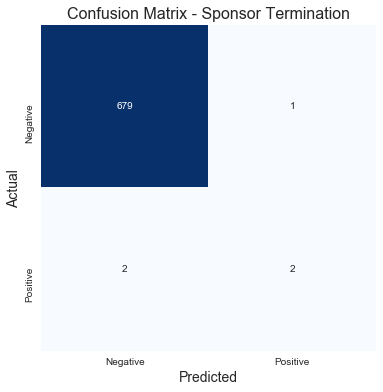

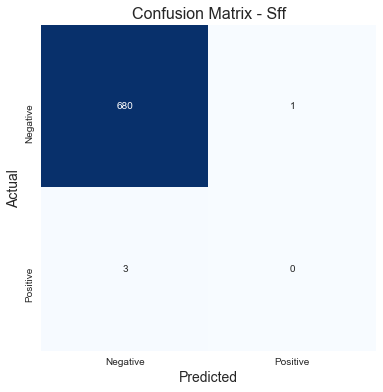

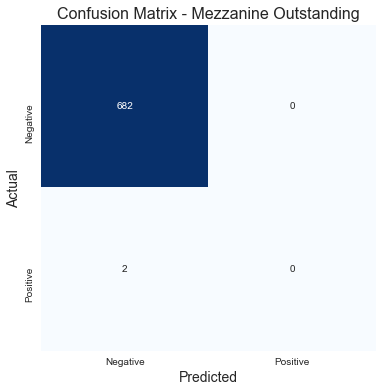

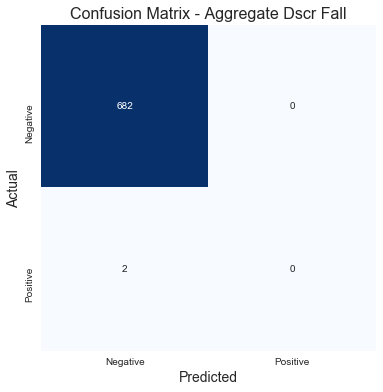

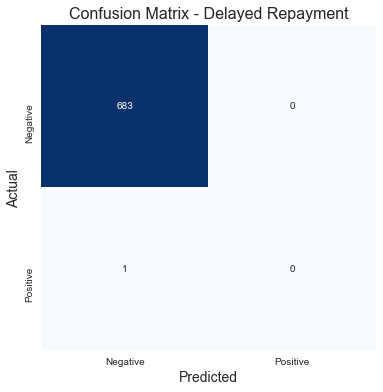

In [18]:
create_confusion_matrix(results_df)

In [19]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [20]:
results_df.reset_index(inplace = True)

In [21]:
def create_summary_result_table(results_df):
    
    global final_misclassified_as_true
    global final_misclassified_as_false
    
    target_list = results_df['target'].values.tolist()
    final_columns = ['prediction', 'actual'] + target_list
    
    final_misclassified_as_true = pd.DataFrame(columns = final_columns)
    final_misclassified_as_false = pd.DataFrame(columns = final_columns)

    for row in results_df.itertuples(index = True, name = 'Pandas'):
        best_model = getattr(row, "model_result").best_estimator_
        preds = best_model.predict(getattr(row, "split_data")['X_test'])
        
        index_list = list(getattr(row, "split_data")['indices_test'])
        preds_list = list(preds.astype(int))
        actuals_list = list(getattr(row, "split_data")['y_test'].astype(int))
        
        results = pd.DataFrame({'index': index_list, 'prediction': preds_list, 'actual': actuals_list})
        results.set_index('index', inplace = True)
        
        misclassified = results[results['prediction'] != results['actual']]
        misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)
        misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
        misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
        
        misclassified_as_true_summary = misclassified_as_true.drop(columns = ['Document', 'Sentence', 'SentenceTokens', 'SentenceLemmas'])
        misclassified_as_false_summary = misclassified_as_false.drop(columns = ['Document', 'Sentence', 'SentenceTokens', 'SentenceLemmas'])
        
        
        misclassified_as_true_summary.loc[f'{getattr(row, "target")}',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)
        misclassified_as_false_summary.loc[f'{getattr(row, "target")}',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)

        
        final_misclassified_as_true = final_misclassified_as_true.append(misclassified_as_true_summary.iloc[-1], ignore_index = False)
        final_misclassified_as_false = final_misclassified_as_false.append(misclassified_as_false_summary.iloc[-1], ignore_index = False)
        
    return final_misclassified_as_true
    return final_misclassified_as_false
        
 

In [22]:
create_summary_result_table(results_df)

,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,bankruptcy,tenant_failure,renovations,aggregate_debt_yield_fall,dscr_fall,operator_termination,sponsor_termination,sff,mezzanine_outstanding,aggregate_dscr_fall,delayed_repayment
nontrigger,7.0,0.0,0,1,0,0,0,0,1,2,0,0,2,0,1,0,0,0
loan_default,9.0,0.0,2,0,4,3,0,0,0,0,0,0,0,0,0,0,0,0
unspecified,17.0,0.0,6,7,0,0,0,0,0,0,0,0,2,0,0,2,0,0
debt_yield_fall,3.0,0.0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0
mezzanine_default,6.0,0.0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0
bankruptcy,1.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tenant_failure,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
renovations,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dscr_fall,3.0,0.0,0,2,0,0,0,2,1,0,0,0,0,0,0,0,2,0


In [23]:
results_df.set_index('target', inplace = True)

In [24]:
final_misclassified_as_true

,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,bankruptcy,tenant_failure,renovations,aggregate_debt_yield_fall,dscr_fall,operator_termination,sponsor_termination,sff,mezzanine_outstanding,aggregate_dscr_fall,delayed_repayment
nontrigger,7.0,0.0,0,1,0,0,0,0,1,2,0,0,2,0,1,0,0,0
loan_default,9.0,0.0,2,0,4,3,0,0,0,0,0,0,0,0,0,0,0,0
unspecified,17.0,0.0,6,7,0,0,0,0,0,0,0,0,2,0,0,2,0,0
debt_yield_fall,3.0,0.0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0
mezzanine_default,6.0,0.0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0
bankruptcy,1.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tenant_failure,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
renovations,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dscr_fall,3.0,0.0,0,2,0,0,0,2,1,0,0,0,0,0,0,0,2,0


In [25]:
final_misclassified_as_false = results_df[['count_deduplicated', 'train_score', 'test_score']].merge(final_misclassified_as_false, left_index = True, right_index = True)
final_misclassified_as_false

,count_deduplicated,train_score,test_score,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,bankruptcy,tenant_failure,renovations,aggregate_debt_yield_fall,dscr_fall,operator_termination,sponsor_termination,sff,mezzanine_outstanding,aggregate_dscr_fall,delayed_repayment
nontrigger,1030,0.999823,0.985937,0.0,11.0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loan_default,553,0.999221,0.991220,0.0,10.0,0,10,0,4,4,0,4,0,0,0,0,0,0,0,1,0
unspecified,498,0.999828,0.964248,0.0,16.0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0
debt_yield_fall,188,0.999974,0.993375,0.0,5.0,0,4,0,5,1,1,0,0,0,0,0,0,0,0,0,0
mezzanine_default,72,1.000000,0.994850,0.0,1.0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0
bankruptcy,44,0.999897,0.995529,0.0,3.0,0,3,0,3,1,3,0,0,0,0,0,0,0,0,0,0
tenant_failure,74,1.000000,0.999863,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
renovations,26,0.888889,0.933333,0.0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,19,1.000000,0.800000,0.0,2.0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0
dscr_fall,23,1.000000,0.750000,0.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [26]:
final_misclassified_as_true = results_df[['count_deduplicated', 'test_data_count','train_score', 'test_score']].merge(final_misclassified_as_true, left_index = True, right_index = True)
final_misclassified_as_true

,count_deduplicated,test_data_count,train_score,test_score,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,bankruptcy,tenant_failure,renovations,aggregate_debt_yield_fall,dscr_fall,operator_termination,sponsor_termination,sff,mezzanine_outstanding,aggregate_dscr_fall,delayed_repayment
nontrigger,1030,309,0.999823,0.985937,7.0,0.0,0,1,0,0,0,0,1,2,0,0,2,0,1,0,0,0
loan_default,553,166,0.999221,0.991220,9.0,0.0,2,0,4,3,0,0,0,0,0,0,0,0,0,0,0,0
unspecified,498,149,0.999828,0.964248,17.0,0.0,6,7,0,0,0,0,0,0,0,0,2,0,0,2,0,0
debt_yield_fall,188,56,0.999974,0.993375,3.0,0.0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0
mezzanine_default,72,22,1.000000,0.994850,6.0,0.0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0
bankruptcy,44,13,0.999897,0.995529,1.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tenant_failure,74,22,1.000000,0.999863,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
renovations,26,8,0.888889,0.933333,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,19,6,1.000000,0.800000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dscr_fall,23,7,1.000000,0.750000,3.0,0.0,0,2,0,0,0,2,1,0,0,0,0,0,0,0,2,0


In [27]:
# Export to CSV file

#final_misclassified_as_false.to_csv(f'../data/exported_data/misclassified_as_false_06_16_20.csv')
#final_misclassified_as_true.to_csv(f'../data/exported_data/misclassified_as_true_06_16_20.csv')